In [1]:
import os
import numpy as np
import pandas as pd
import joblib, os, pickle, hashlib, torch, time
import pefile
# from torch.nn.functional import sigmoid
from features import PEFeatureExtractor


c:\Users\vboxuser\miniconda3\envs\malware\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch import nn
from torch.nn import functional as F


class MalConvBase(nn.Module):
    def __init__(self, embed_dim, _, out_channels, window_size, dropout=0.5):
        super(MalConvBase, self).__init__()
        self.embed = nn.Embedding(257, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels * 2,
            kernel_size=window_size,
            stride=window_size,
        )
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        glu_out = F.glu(conv_out, dim=1)
        values, _ = glu_out.max(dim=-1)
        output = self.fc(values).squeeze(1)
        return output


class MalConvPlus(nn.Module):
    def __init__(self, embed_dim, max_len, out_channels, window_size, dropout=0.5):
        super(MalConvPlus, self).__init__()
        self.tok_embed = nn.Embedding(257, embed_dim)
        self.pos_embed = nn.Embedding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels * 2,
            kernel_size=window_size,
            stride=window_size,
        )
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        tok_embedding = self.tok_embed(x)
        pos = torch.arange(seq_len).unsqueeze(0).repeat(batch_size, 1).to(x.device)
        pos_embedding = self.pos_embed(pos)
        embedding = self.dropout(tok_embedding + pos_embedding)
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        glu_out = F.glu(conv_out, dim=1)
        values, _ = glu_out.max(dim=-1)
        output = self.fc(values).squeeze(1)
        return output


class RCNN(nn.Module):
    def __init__(
        self,
        embed_dim,
        out_channels,
        window_size,
        module,
        hidden_size,
        num_layers,
        bidirectional,
        residual,
        dropout=0.5,
    ):
        super(RCNN, self).__init__()
        assert module.__name__ in {
            "RNN",
            "GRU",
            "LSTM",
        }, "`module` must be a `torch.nn` recurrent layer"
        self.residual = residual
        self.embed = nn.Embedding(257, embed_dim)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=window_size,
            stride=window_size,
        )
        self.rnn = module(
            input_size=out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        self.dropout = nn.Dropout(dropout)
        rnn_out_size = (int(bidirectional) + 1) * hidden_size
        if residual:
            self.fc = nn.Linear(out_channels + rnn_out_size, 1)
        else:
            self.fc = nn.Linear(rnn_out_size, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        if self.residual:
            values, _ = conv_out.max(dim=-1)
        conv_out = conv_out.permute(2, 0, 1)
        rnn_out, _ = self.rnn(conv_out)
        fc_in = rnn_out[-1]
        if self.residual:
            fc_in = torch.cat((fc_in, values), dim=-1)
        output = self.fc(fc_in).squeeze(1)
        return output


class AttentionRCNN(nn.Module):
    def __init__(
        self,
        embed_dim,
        out_channels,
        window_size,
        module,
        hidden_size,
        num_layers,
        bidirectional,
        attn_size,
        residual,
        dropout=0.5,
    ):
        super(AttentionRCNN, self).__init__()
        assert module.__name__ in {
            "RNN",
            "GRU",
            "LSTM",
        }, "`module` must be a `torch.nn` recurrent layer"
        self.residual = residual
        self.embed = nn.Embedding(257, embed_dim)
        self.conv = nn.Conv1d(
            in_channels=embed_dim,
            out_channels=out_channels,
            kernel_size=window_size,
            stride=window_size,
        )
        self.rnn = module(
            input_size=out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        rnn_out_size = (int(bidirectional) + 1) * hidden_size
        self.local2attn = nn.Linear(rnn_out_size, attn_size)
        self.global2attn = nn.Linear(rnn_out_size, attn_size, bias=False)
        self.attn_scale = nn.Parameter(
            nn.init.kaiming_uniform_(torch.empty(attn_size, 1))
        )
        self.dropout = nn.Dropout(dropout)
        if residual:
            self.fc = nn.Linear(out_channels + rnn_out_size, 1)
        else:
            self.fc = nn.Linear(rnn_out_size, 1)

    def forward(self, x):
        embedding = self.dropout(self.embed(x))
        conv_in = embedding.permute(0, 2, 1)
        conv_out = self.conv(conv_in)
        if self.residual:
            values, _ = conv_out.max(dim=-1)
        conv_out = conv_out.permute(2, 0, 1)
        rnn_out, _ = self.rnn(conv_out)
        global_rnn_out = rnn_out.mean(dim=0)
        attention = torch.tanh(
            self.local2attn(rnn_out) + self.global2attn(global_rnn_out)
        ).permute(1, 0, 2)
        alpha = F.softmax(attention.matmul(self.attn_scale), dim=-1)
        rnn_out = rnn_out.permute(1, 0, 2)
        fc_in = (alpha * rnn_out).sum(dim=1)
        if self.residual:
            fc_in = torch.cat((fc_in, values), dim=-1)
        output = self.fc(fc_in).squeeze(1)
        return output

In [2]:
import pefile

def extract_features(data):
    """
    Extract features from the given binary data (a byte string).

    :param data: The binary data from which to extract features.
    :return: A list of feature values.
    """
    pe = pefile.PE(data=data)

    # Extract features from the PE file
    features = {}
    features["Machine"] = pe.FILE_HEADER.Machine
    features["NumberOfSections"] = pe.FILE_HEADER.NumberOfSections
    features["TimeDateStamp"] = pe.FILE_HEADER.TimeDateStamp
    features["PointerToSymbolTable"] = pe.FILE_HEADER.PointerToSymbolTable
    features["NumberOfSymbols"] = pe.FILE_HEADER.NumberOfSymbols
    features["SizeOfOptionalHeader"] = pe.FILE_HEADER.SizeOfOptionalHeader
    features["Characteristics"] = pe.FILE_HEADER.Characteristics
    features["Magic"] = pe.OPTIONAL_HEADER.Magic
    features["MajorLinkerVersion"] = pe.OPTIONAL_HEADER.MajorLinkerVersion
    features["MinorLinkerVersion"] = pe.OPTIONAL_HEADER.MinorLinkerVersion
    features["SizeOfCode"] = pe.OPTIONAL_HEADER.SizeOfCode
    features["SizeOfInitializedData"] = pe.OPTIONAL_HEADER.SizeOfInitializedData
    features["SizeOfUninitializedData"] = pe.OPTIONAL_HEADER.SizeOfUninitializedData
    features["AddressOfEntryPoint"] = pe.OPTIONAL_HEADER.AddressOfEntryPoint
    features["BaseOfCode"] = pe.OPTIONAL_HEADER.BaseOfCode
    features["ImageBase"] = pe.OPTIONAL_HEADER.ImageBase
    features["SectionAlignment"] = pe.OPTIONAL_HEADER.SectionAlignment
    features["FileAlignment"] = pe.OPTIONAL_HEADER.FileAlignment
    features["MajorOperatingSystemVersion"] = pe.OPTIONAL_HEADER.MajorOperatingSystemVersion
    features["MinorOperatingSystemVersion"] = pe.OPTIONAL_HEADER.MinorOperatingSystemVersion
    features["MajorImageVersion"] = pe.OPTIONAL_HEADER.MajorImageVersion
    features["MinorImageVersion"] = pe.OPTIONAL_HEADER.MinorImageVersion
    features["MajorSubsystemVersion"] = pe.OPTIONAL_HEADER.MajorSubsystemVersion
    features["MinorSubsystemVersion"] = pe.OPTIONAL_HEADER.MinorSubsystemVersion
    features["SizeOfImage"] = pe.OPTIONAL_HEADER.SizeOfImage
    features["SizeOfHeaders"] = pe.OPTIONAL_HEADER.SizeOfHeaders
    features["CheckSum"] = pe.OPTIONAL_HEADER.CheckSum
    features["Subsystem"] = pe.OPTIONAL_HEADER.Subsystem
    features["DllCharacteristics"] = pe.OPTIONAL_HEADER.DllCharacteristics
    features["SizeOfStackReserve"] = pe.OPTIONAL_HEADER.SizeOfStackReserve
    features["SizeOfStackCommit"] = pe.OPTIONAL_HEADER.SizeOfStackCommit
    features["SizeOfHeapReserve"] = pe.OPTIONAL_HEADER.SizeOfHeapReserve
    features["SizeOfHeapCommit"] = pe.OPTIONAL_HEADER.SizeOfHeapCommit
    features["LoaderFlags"] = pe.OPTIONAL_HEADER.LoaderFlags
    features["NumberOfRvaAndSizes"] = pe.OPTIONAL_HEADER.NumberOfRvaAndSizes

    return features, list(pe.header)

    

In [3]:
def extract_features(data):
    extractor = PEFeatureExtractor(2)
    # temp = extractor.feature_vector(data)
    # print(temp)
    features = np.array(extractor.feature_vector(data), dtype=np.float32)
    pe = pefile.PE(data=data)
    return [features], list(pe.header)


# RF 1

In [11]:
result = []
test = r"./datasets\gw2\0000"
with open(test, "rb") as f:
    data = f.read()
features_data, header = extract_features(data)

[0.02374453 0.00291841 0.00273137 ... 0.         0.         0.        ]


In [13]:
clf = joblib.load("../models/malware_classifier_v2.joblib")
features = pickle.load(open("../models/features.pkl", "rb"))
clf.predict_proba(features_data)
# pe_features = np.array([features_data[feature] for feature in features])
# y_pred = clf.predict_proba([pe_features])
# predictions.append(int(prediction1[0]))

array([[0.45078584, 0.54921416]])

# Malconv

In [20]:
# Load Malconv Model
embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_v2.pt"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
model.load_state_dict(torch.load(weight_path))
model.to(device)
model.eval()
input = torch.tensor(header).unsqueeze(0).to(device)
y_pred2 = sigmoid(model(input))



# Bodas RF

In [21]:
bodmas_clf = joblib.load("../models/bodmas/model.joblib")
y_pred3 = bodmas_clf.predict_proba([pe_features])

In [26]:
result.append(y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist()[0])

# Testing

In [14]:
basePath = "./datasets"
all_results = []
# load RF models
clf = joblib.load("../models/malware_classifier_v2.joblib")
# bodmas_clf = joblib.load("../models/bodmas/model.joblib")
# features = pickle.load(open("../models/features.pkl", "rb"))
# Load Malconv Model
embed_dim = 8
max_len = 4096
out_channels = 128
window_size = 32
dropout = 0.5
weight_path = "../models/malconv_v2.pt"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
malconv = MalConvPlus(embed_dim, max_len, out_channels, window_size, dropout)
malconv.load_state_dict(torch.load(weight_path))
malconv.to(device)
malconv.eval()

for folder in os.listdir(basePath):
    if "mw" in folder:
        label = 1
    else:
        label = 0
    results = []
    folderPath = os.path.join(basePath, folder)
    fileCount = 0
    if os.path.isfile(folderPath):
        continue
    for file in os.listdir(folderPath):
        filePath = os.path.join(folderPath, file)
        # print(filePath)
        # break
        with open(filePath, "rb") as f :
            data = f.read()
        try:
            features_data, header = extract_features(data)
        except:
            # results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0, 1.0, 0.0])
            results.append([folder+"_"+file] + [folder] + [label] + [1.0, 0.0, 0.0])
            continue
        input = torch.tensor(header).unsqueeze(0).to(device)
        y_pred = clf.predict_proba(features_data)
        y_pred2 = torch.sigmoid(malconv(input))
        # pe_features = np.array([features_data[feature] for feature in features])
        # y_pred3 = bodmas_clf.predict_proba([pe_features])
        # results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() + y_pred3.tolist()[0])
        results.append([folder+"_"+file] + [folder] + [label] +y_pred.tolist()[0] + y_pred2.tolist() )
        # break
    all_results += results
    # break
# all_results

lief error:  This file is not a PE binary


In [15]:
# df = pd.DataFrame(all_results, columns=["FileName", "Dataset", "Label", "y_pred0_0", "y_pred0_1", "y_pred1", "y_pred2_0", "y_pred2_1"])
df = pd.DataFrame(all_results, columns=["FileName", "Dataset", "Label", "y_pred0_0", "y_pred0_1", "y_pred1"])
df2 = df
# len(all_results)

In [12]:
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,y_pred2_0,y_pred2_1
0,gw2_0000,gw2,0,0.450786,0.549214,0.817315,NaN,NaN
1,gw2_0001,gw2,0,0.433744,0.566256,0.782296,NaN,NaN
2,gw2_0002,gw2,0,0.280016,0.719984,0.000407,NaN,NaN
3,gw2_0003,gw2,0,0.180803,0.819197,0.010278,NaN,NaN
4,gw2_0004,gw2,0,0.280012,0.719988,0.956456,NaN,NaN


In [16]:
# df['pred0_label'] = (df['y_pred0_1'] > 0.45).astype(int)
df['pred1_label'] = (df['y_pred1'] > 0.45).astype(int)
# df['pred2_label'] = (df['y_pred2_1'] > 0.45).astype(int)

df['pred0_label'] = df[['y_pred0_0', 'y_pred0_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
# df['pred2_label'] = df[['y_pred2_0', 'y_pred2_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
df.head()

,FileName,Dataset,Label,y_pred0_0,y_pred0_1,y_pred1,pred1_label,pred0_label
0,gw2_0000,gw2,0,0.450786,0.549214,0.817315,1,1
1,gw2_0001,gw2,0,0.433744,0.566256,0.782296,1,1
2,gw2_0002,gw2,0,0.280016,0.719984,0.000407,0,1
3,gw2_0003,gw2,0,0.180803,0.819197,0.010278,0,1
4,gw2_0004,gw2,0,0.280012,0.719988,0.956456,1,1


In [17]:
df.to_csv("all_reults_v2.csv")

In [19]:
def calculate_accuracy(group):
    acc_pred0 = (group['pred0_label'] == group['Label']).mean()
    acc_pred1 = (group['pred1_label'] == group['Label']).mean()
    # acc_pred2 = (group['pred2_label'] == group['Label']).mean()
    # return pd.Series({'Accuracy_pred0': acc_pred0, 'Accuracy_pred1': acc_pred1, 'Accuracy_pred2': acc_pred2})
    return pd.Series({'Accuracy_pred0': acc_pred0, 'Accuracy_pred1': acc_pred1})

# Group by 'Dataset' and apply the accuracy function
accuracy_results = df.groupby('Dataset').apply(calculate_accuracy)
accuracy_results

,Accuracy_pred0,Accuracy_pred1
Dataset,,
gw2,0.117647,0.529412
gw3,0.396552,0.603448
gw4,0.591837,0.591837
gw5,0.561644,0.287671
gw6,1.000000,0.951220
mw1,0.375000,0.750000
mw2,0.800000,0.880000
mw3,0.316667,0.700000
mw4,0.655172,0.724138


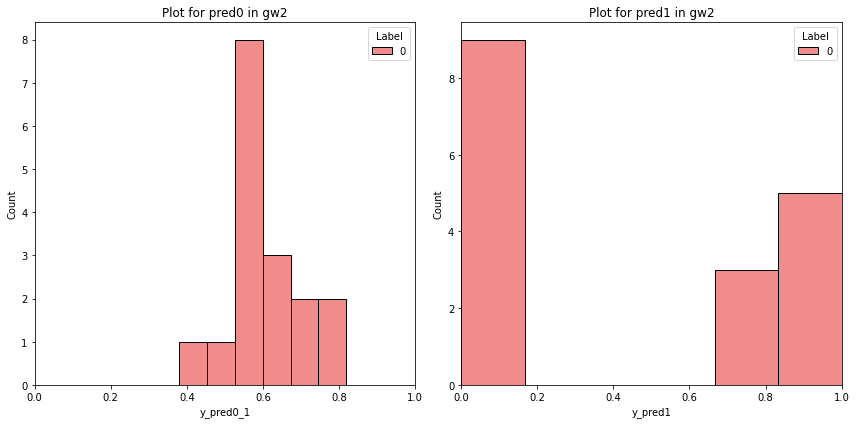

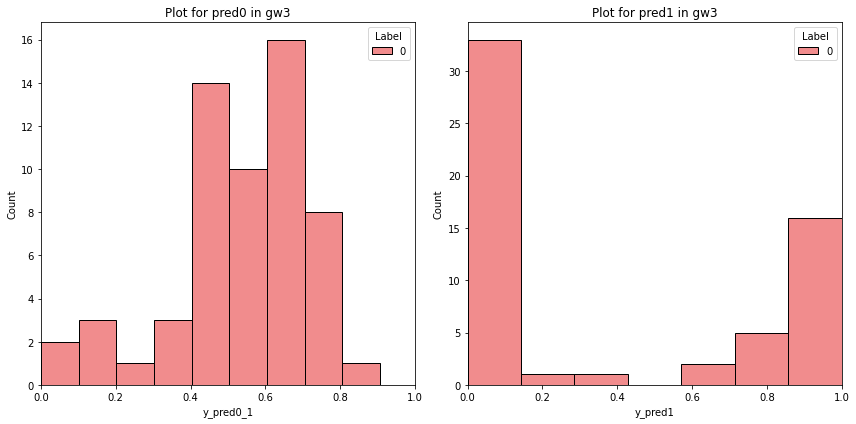

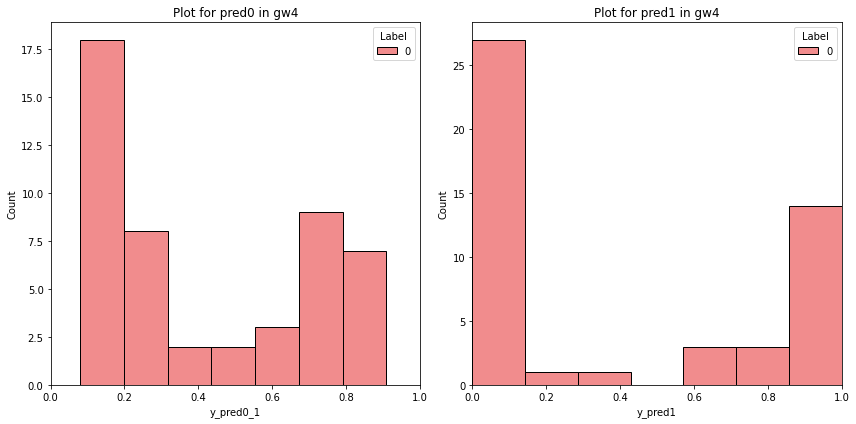

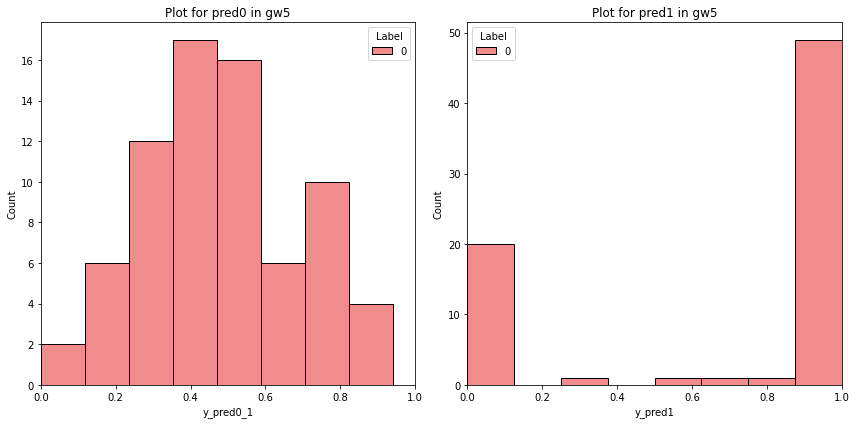

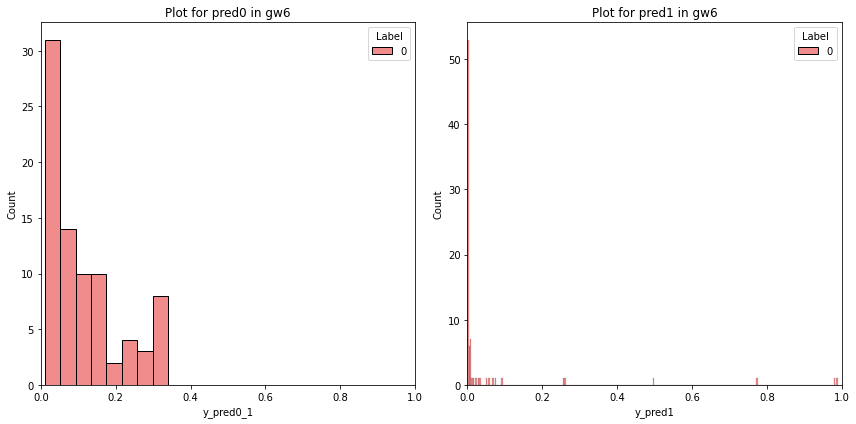

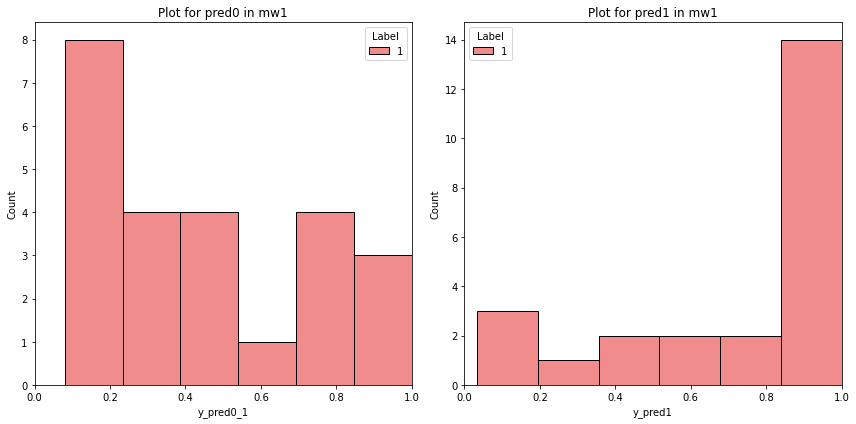

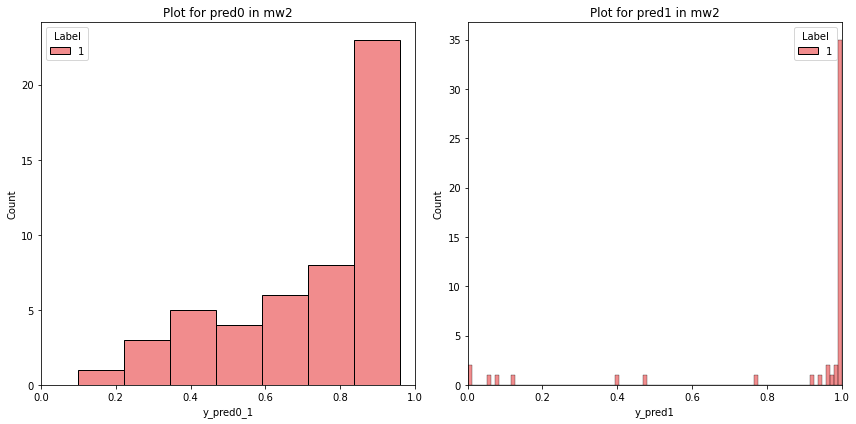

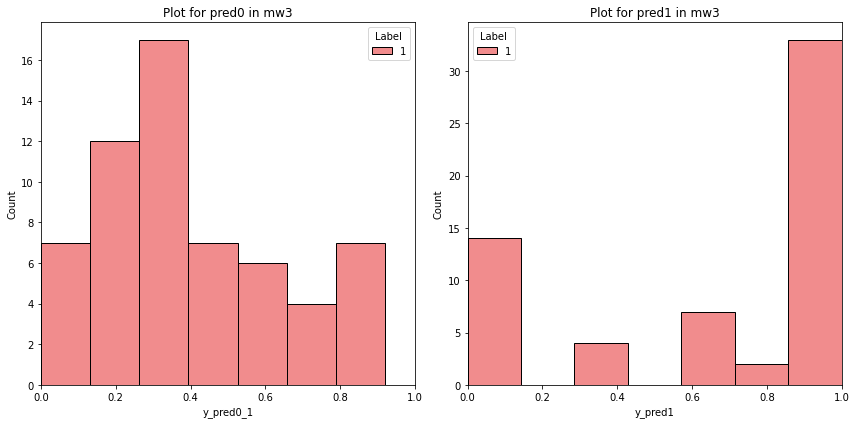

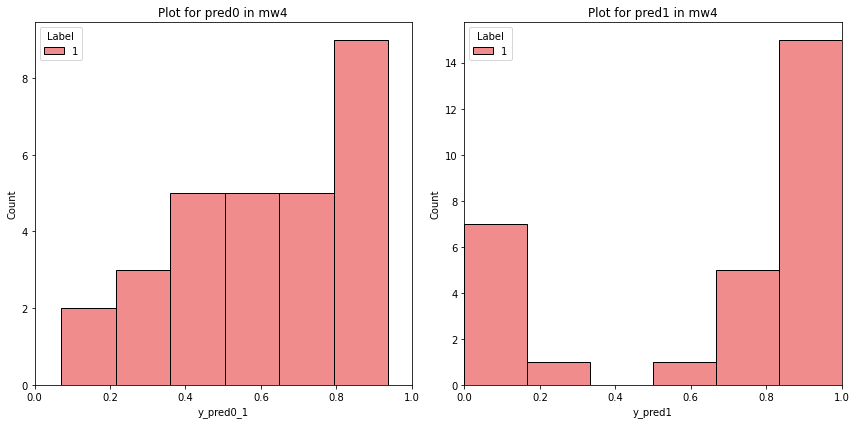

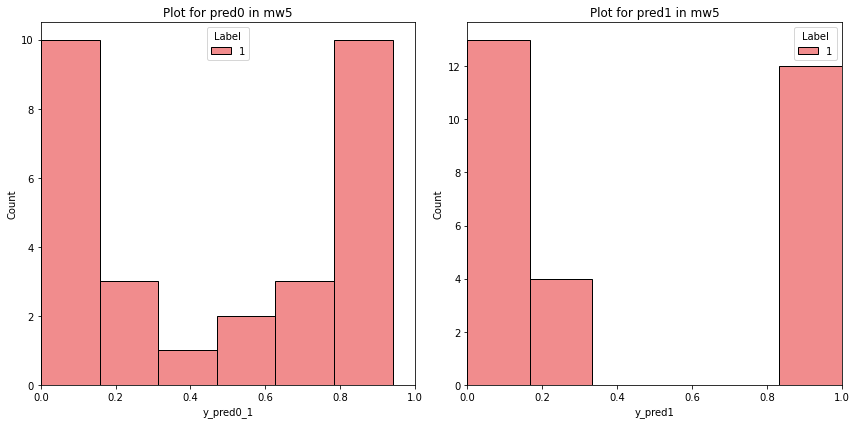

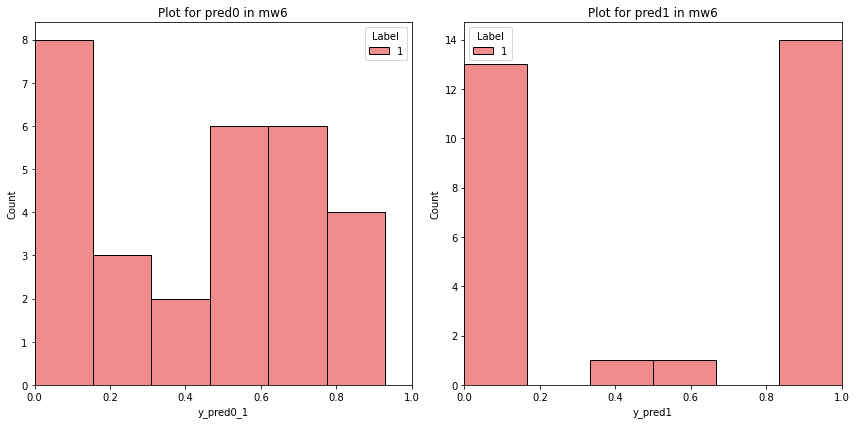

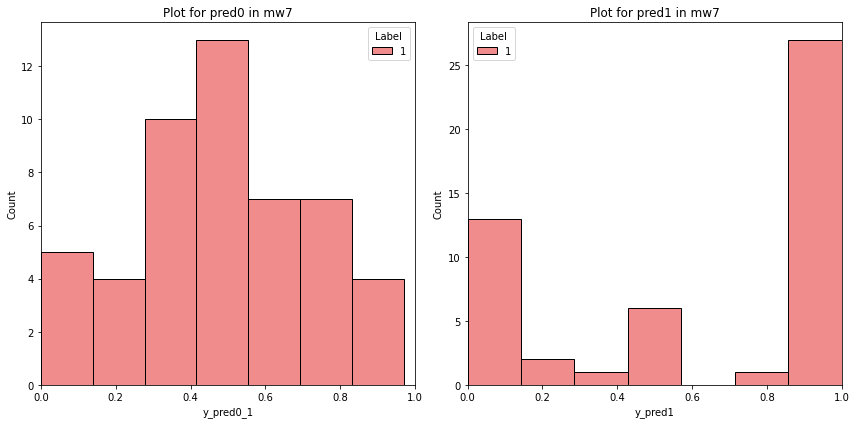

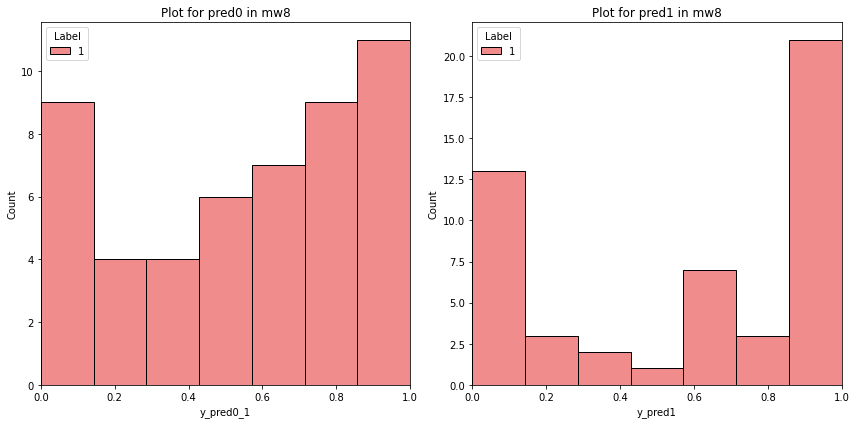

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
# Adding new columns for predicted labels
df['pred0_label'] = df[['y_pred0_0', 'y_pred0_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
df['pred1_label'] = (df['y_pred1'] > 0.5).astype(int)
# df['pred2_label'] = df[['y_pred2_0', 'y_pred2_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))


# Adding columns for correctness
df['correct_pred0'] = (df['pred0_label'] == df['Label']).astype(int)
df['correct_pred1'] = (df['pred1_label'] == df['Label']).astype(int)
# df['correct_pred2'] = (df['pred2_label'] == df['Label']).astype(int)

datasets = df['Dataset'].unique()
for dataset in datasets:
    plt.figure(figsize=(12, 6))
        
        # Data filtered by current dataset
    data_subset = df[df['Dataset'] == dataset]
    # data_subset = df
    # dataset = ""
    # Plot for pred0
    plt.subplot(1, 2, 1)
    # sns.scatterplot(data=data_subset, x='y_pred0_0', y='y_pred0_1', hue='correct_pred0', style='Dataset',
    #                 palette='Set1', markers=True, legend='full')
    # col_name = 'y_pred0_0' if "gw" in dataset else 'y_pred0_1'
    sns.histplot(data=data_subset, x='y_pred0_1', hue='Label', palette='Set1', fill=True)
    plt.title(f'Plot for pred0 in {dataset}')
    # plt.xlabel('Benign Probability')
    # plt.ylabel('Malware Probability')
    plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
    # plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1

    plt.subplot(1, 2, 2)
    # sns.scatterplot(data=data_subset, x='y_pred0_0', y='y_pred0_1', hue='correct_pred0', style='Dataset',
    #                 palette='Set1', markers=True, legend='full')
    # col_name = 'y_pred1_0' if "gw" in dataset else 'y_pred0_1'
    # plt.xlabel('Benign Probability')
    # plt.ylabel('Malware Probability')
    sns.histplot(data=data_subset, x='y_pred1', hue='Label', palette='Set1', fill=True)
    plt.title(f'Plot for pred1 in {dataset}')
    plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
    # plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1

    # # Plot for pred2
    # plt.subplot(1, 3, 3)
    # # col_name = 'y_pred2_0' if "gw" in dataset else 'y_pred2_1'
    # # sns.scatterplot(data=data_subset, x='y_pred2_0', y='y_pred2_1', hue='correct_pred2', style='Dataset',
    #                 # palette='Set1', markers=True, legend='full')
    # # plt.xlabel('Benign Probability')
    # # plt.ylabel('Malware Probability')
    # sns.histplot(data=data_subset, x='y_pred2_1', hue='Label', palette='Set1', fill=True)
    # plt.title(f'Plot for pred2 in {dataset}')
    # plt.xlim(0, 1)  # Set the x-axis limits from 0 to 1
    # plt.ylim(0, 1)  # Set the y-axis limits from 0 to 1
    # Show plot
    plt.tight_layout()
    plt.show()